#### 1. 우선 TorchResource에 존재하는 DeepLabv3 모델을 이용해서 이미지 한장에 전이 학습을 진행해 보고자 한다.  
- DeepLabv3에 들어가는 사전 조건들
```py3
def deeplabv3_resnet101(pretrained=False, progress=True,
                        num_classes=21, aux_loss=None, **kwargs)
```     
                     
1.  위와 같이 저장 되어있는 resnet101을 이용한 deeplabv3모델을 사용하고자 한다.
  - 해당 모델을 불러와서 사용하기 위해서는 아래와 같은 parameter값들을 설정해 주어야 한다.  
    - **pretrained (bool)** – If True, returns a model pre-trained on COCO train2017 which contains the same classes as Pascal VOC
    - **progress (bool)** – If True, displays a progress bar of the download to stderr
    - **num_classes (int)** – The number of classes
    - **aux_loss (bool)** – If True, include an auxiliary classifier

2. 전이 학습을 진행하기 위해서는 당연히 미리 이미지들을 미리 바꾸어 주어야 하며, 이는 torchvision.transforms 모듈을 사용하면 쉽게 해결이 가능하다.
```py
preprocess = transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean = [0.485, 0.486, 0.486], std = [0.299, 0.224, 0.225])
])
```  

3. 또한 이미지들은 적어도 224 픽셀은 가지고 있어야 하며 255로 나눔으로서 픽셀값의 범위를 0-1로 바꾸어 주어야 한다.

4. 21개의 class로 나누어주는데,  
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor"  

  의 순서로 이루어져 있다.

In [ ]:
import torch
model = torch.hub.load('pytorch/vision:v0.9.0', 'deeplabv3_resnet101', pretrained = True)
model.eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.9.0.zip" to /root/.cache/torch/hub/v0.9.0.zip
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [ ]:
import urllib
#url, filename = ("https://content.skyscnr.com/m/6edb85be7ee43066/original/GettyImages-502095278.jpg", "elephant.jpg")
#url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
url, filename = ("http://image.kmib.co.kr/online_image/2020/0920/611718110015025888_1.jpg", "herdofDogs.jpg")
try:
  urllib.URLopener().retrieve(url, filename)
except:
  urllib.request.urlretrieve(url, filename)

In [ ]:
from PIL import Image
from torchvision import transforms
input_img = Image.open(filename)

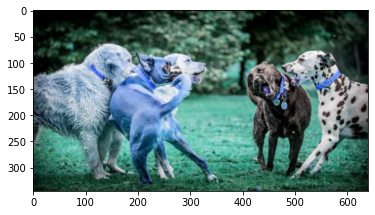

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img)

In [ ]:
import cv2
img = cv2.imread(filename)
print(img.shape)

(345, 640, 3)


In [ ]:
preprocess = transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean = [0.485, 0.486, 0.486], std = [0.299, 0.224, 0.225])
])

In [ ]:
input_tensor = preprocess(input_img)
input_batch = input_tensor.unsqueeze(0)

In [ ]:
if torch.cuda.is_available():
  input_batch = input_batch.to('cuda')
  model.to('cuda')
with torch.no_grad():
  output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)

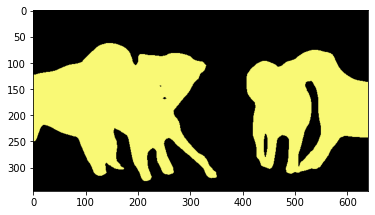

In [ ]:
palette = torch.tensor([2**55-1, 2**15-1, 2**21-1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors%255).numpy().astype("uint8")

r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_img.size)
r.putpalette(colors)

import matplotlib.pyplot as plt
plt.imshow(r)

#### PyTorch에서 제공하는 DeepLabv3의 Model Architecture
1. Atrous Convolution
2. Spatial Pyramid Pooling
3. Encoder - Decoder

- 위와 같은 3개의 기능을 첨부해서 class DeepLabV3를 설계
- _SimpleSegmentationModel 클래스를 만들어서 모델 DeepLabV3의 모듈로 설정을 해줌
- nn.Module을 이용해서 모델을 설계할 때에 필요한 함수는 일단은 __init__과 forward(), 두개의 함수가 존재한다.


cf01. Tensorflow에서처럼 Sequential을 이용해서 깊이가 작은 모델을 만든다.
```py
# Using Sequential to create a small model. When `model` is run,
# input will first be passed to `Conv2d(1,20,5)`. The output of
# `Conv2d(1,20,5)` will be used as the input to the first
# `ReLU`; the output of the first `ReLU` will become the input
# for `Conv2d(20,64,5)`. Finally, the output of
# `Conv2d(20,64,5)` will be used as input to the second `ReLU`
model = nn.Sequential(
          nn.Conv2d(1,20,5),
          nn.ReLU(),
          nn.Conv2d(20,64,5),
          nn.ReLU()
        )

# Using Sequential with OrderedDict. This is functionally the
# same as the above code
model = nn.Sequential(OrderedDict([
          ('conv1', nn.Conv2d(1,20,5)),
          ('relu1', nn.ReLU()),
          ('conv2', nn.Conv2d(20,64,5)),
          ('relu2', nn.ReLU())
        ]))
```     

cf02. CLASS torch.nn.Module을 이용
- 모든 neural network module의 기본이 되는 class이다.
- Module들은 다른 Module을 포함할 수 있다.
```py
import torch.nn as nn
import torch.nn.functional as F
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5)
        self.conv2 = nn.Conv2d(20, 20, 5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        return F.relu(self.conv2(x))
```



In [ ]:
from collections import OrderedDict

import torch.nn as nn
from torch.nn import functional as F


class _SimpleSegmentationModel(nn.Module):
    __constants__ = ['aux_classifier']

    def __init__(self, backbone, classifier, aux_classifier=None):
        super(_SimpleSegmentationModel, self).__init__()
        self.backbone = backbone
        self.classifier = classifier
        self.aux_classifier = aux_classifier

    def forward(self, x):
        input_shape = x.shape[-2:]
        # contract: features is a dict of tensors
        features = self.backbone(x)

        result = OrderedDict()
        x = features["out"]
        x = self.classifier(x)
        x = F.interpolate(x, size=input_shape, mode='bilinear', align_corners=False)
        result["out"] = x

        if self.aux_classifier is not None:
            x = features["aux"]
            x = self.aux_classifier(x)
            x = F.interpolate(x, size=input_shape, mode='bilinear', align_corners=False)
            result["aux"] = x

        return result

#### Atrous Convolution
- controls the spacing between the kernel points, also known as the atrous algorithm
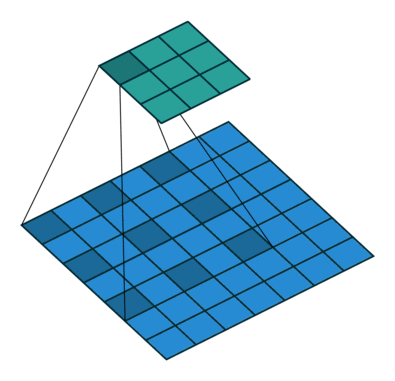

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F



__all__ = ["DeepLabV3"]


class DeepLabV3(_SimpleSegmentationModel): #_SimpleSegmentationModel이 DeepLabV3을 포함한 구조
    """
    Implements DeepLabV3 model from
    `"Rethinking Atrous Convolution for Semantic Image Segmentation"
    <https://arxiv.org/abs/1706.05587>`_.
    Args:
        backbone (nn.Module): the network used to compute the features for the model.
            The backbone should return an OrderedDict[Tensor], with the key being
            "out" for the last feature map used, and "aux" if an auxiliary classifier
            is used.
        classifier (nn.Module): module that takes the "out" element returned from
            the backbone and returns a dense prediction.
        aux_classifier (nn.Module, optional): auxiliary classifier used during training
    """
    pass


class DeepLabHead(nn.Sequential):
    def __init__(self, in_channels, num_classes):
        super(DeepLabHead, self).__init__(
            ASPP(in_channels, [12, 24, 36]),
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, num_classes, 1)
        )


class ASPPConv(nn.Sequential):
    def __init__(self, in_channels, out_channels, dilation):
        modules = [
            nn.Conv2d(in_channels, out_channels, 3, padding=dilation, dilation=dilation, bias=False), 
            # Convolution에서 atrous convolution을 dilation parmeter을 이용해 적용하였음이 확인 가능하다.
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ]
        super(ASPPConv, self).__init__(*modules)


class ASPPPooling(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super(ASPPPooling, self).__init__(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU())

    def forward(self, x):
        size = x.shape[-2:]
        for mod in self:
            x = mod(x)
        return F.interpolate(x, size=size, mode='bilinear', align_corners=False)


class ASPP(nn.Module):
    def __init__(self, in_channels, atrous_rates, out_channels=256):
        super(ASPP, self).__init__()
        modules = []
        modules.append(nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()))

        rates = tuple(atrous_rates)
        for rate in rates:
            modules.append(ASPPConv(in_channels, out_channels, rate))

        modules.append(ASPPPooling(in_channels, out_channels))

        self.convs = nn.ModuleList(modules)

        self.project = nn.Sequential(
            nn.Conv2d(len(self.convs) * out_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.5))

    def forward(self, x):
        res = []
        for conv in self.convs:
            res.append(conv(x))
        res = torch.cat(res, dim=1)
        return self.project(res)

In [ ]:
import tensorflow as tf
import numpy as np
import os, random
import tensorflow.contrib.slim as slim

from tqdm import tqdm
from custom_op import conv2d, conv2d_t, atrous_conv2d, max_pool, lrelu, bn, relu
from utils import read_data_path, next_batch, read_image, read_annotation, draw_plot_segmentation


class DeepLab_v2(object):
    MODEL = 'DeepLab_v2'

    def __init__(self, epoch, batch, learning_rate):
        self.N_EPOCH = epoch
        self.N_BATCH = batch
        self.LEARNING_RATE = learning_rate

        self.MODEL_NAME = 'DeepLab_v2'

        self.LOGS_DIR = os.path.join(self.MODEL_NAME+'_result', 'logs')
        self.CKPT_DIR = os.path.join(self.MODEL_NAME+'_result', 'ckpt')
        self.OUTPUT_DIR = os.path.join(self.MODEL_NAME+'_result', 'output')
        
        self.N_CLASS = 151
        self.RESIZE = 192
        
        self.TRAIN_IMAGE_PATH = './DATA/ADEChallengeData2016/images/training/'
        self.TRAIN_LABEL_PATH = './DATA/ADEChallengeData2016/annotations/training/'

        self.VALID_IMAGE_PATH = './DATA/ADEChallengeData2016/images/validation2/'
        self.VALID_LABEL_PATH = './DATA/ADEChallengeData2016/annotations/validation2/'

    
    def make_model(self, inputs, is_training):
        """
            extract feature using ResNet. Encoder
        """
        with tf.variable_scope('ResNet50'):
            x = conv2d(inputs, 64, [7, 7], strides=[1, 2, 2, 1], name='conv1')    # size 1/2
            x = bn(x, is_training)
            x = relu(x)
            x = max_pool(x, ksize=[1, 3, 3, 1], name='pool1')                        # size 1/4

            x = self.conv_block(x, [64, 64, 256], '2_1', is_training, s=1)
            x = self.identity_block(x, [64, 64, 256], '2_2', is_training)
            x = self.identity_block(x, [64, 64, 256], '2_3', is_training)

            x = self.conv_block(x, [128, 128, 512], '3_1', is_training)
            x = self.identity_block(x, [128, 128, 512], '3_2', is_training)
            x = self.identity_block(x, [128, 128, 512], '3_3', is_training)

            x = self.atrous_conv_block(x, [256, 256, 1024], '4_1', 2, is_training, s=1)
            x = self.atrous_identity_block(x, [256, 256, 1024], '4_2', 2, is_training)
            x = self.atrous_identity_block(x, [256, 256, 1024], '4_3', 2, is_training)
            x = self.atrous_identity_block(x, [256, 256, 1024], '4_4', 2, is_training)
            x = self.atrous_identity_block(x, [256, 256, 1024], '4_5', 2, is_training)
            x = self.atrous_identity_block(x, [256, 256, 1024], '4_6', 2, is_training)

            x = self.atrous_conv_block(x, [512, 512, 2048], '5_1', 4, is_training, s=1)
            x = self.atrous_identity_block(x, [512, 512, 2048], '5_2', 4, is_training)
            x = self.atrous_identity_block(x, [512, 512, 2048], '5_3', 4, is_training)

        """
            Astrous Pyrimid Pooling. Decoder
        """
        with tf.variable_scope('ASPP'):
            rate6 = atrous_conv2d(x, self.N_CLASS, [3, 3], 6, name='rate6')
            rate6 = conv2d(rate6, self.N_CLASS, [1, 1], name='rate6_conv1')
            rate6 = conv2d(rate6, self.N_CLASS, [1, 1], name='rate6_conv2')

            rate12 = atrous_conv2d(x, self.N_CLASS, [3, 3], 12, name='rate12')
            rate12 = conv2d(rate12, self.N_CLASS, [1, 1], name='rate12_conv1')
            rate12 = conv2d(rate12, self.N_CLASS, [1, 1], name='rate12_conv2')

            rate18 = atrous_conv2d(x, self.N_CLASS, [3, 3], 18, name='rate18')
            rate18 = conv2d(rate18, self.N_CLASS, [1, 1], name='rate18_conv1')
            rate18 = conv2d(rate18, self.N_CLASS, [1, 1], name='rate18_conv2')
            
            rate24 = atrous_conv2d(x, self.N_CLASS, [3, 3], 24, name='rate24')
            rate24 = conv2d(rate24, self.N_CLASS, [1, 1], name='rate24_conv1')
            rate24 = conv2d(rate24, self.N_CLASS, [1, 1], name='rate24_conv2')

            # self.logits = tf.add_n([rate6, rate12, rate18, rate24])
            # self.out = tf.image.resize_bilinear(self.logits, size=[192, 192])
            add_aspp = tf.add_n([rate6, rate12, rate18, rate24])
            logits = tf.image.resize_bilinear(add_aspp, size=[self.RESIZE, self.RESIZE])

            pred = tf.argmax(logits, axis=3)
            pred = tf.expand_dims(pred, dim=3)

            return logits, pred

    def build_model(self):
        self.input_x = tf.placeholder(dtype=tf.float32, shape=[None, self.RESIZE, self.RESIZE, 3])         # images
        self.label_y = tf.placeholder(dtype=tf.int32, shape=[None, self.RESIZE, self.RESIZE, 1])         # annotations
        self.is_train = tf.placeholder(dtype=tf.bool)

        self.logits, self.pred = self.make_model(self.input_x, self.is_train)
        
        self.loss = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(logits=self.logits, labels=tf.squeeze(self.label_y, [3])))
        
        self.optimizer = tf.train.AdamOptimizer(self.LEARNING_RATE).minimize(self.loss)

        self.loss_summary = tf.summary.merge([tf.summary.scalar('loss', self.loss)])
    
        model_vars = tf.trainable_variables()
        slim.model_analyzer.analyze_vars(model_vars, print_info=True)
        

    
    def train_model(self):
        if not os.path.exists(self.MODEL_NAME+'_result'):   os.mkdir(self.MODEL_NAME+'_result')
        if not os.path.exists(self.LOGS_DIR):   os.mkdir(self.LOGS_DIR)
        if not os.path.exists(self.CKPT_DIR):   os.mkdir(self.CKPT_DIR)
        if not os.path.exists(self.OUTPUT_DIR): os.mkdir(self.OUTPUT_DIR)
        
        train_set_path = read_data_path(self.TRAIN_IMAGE_PATH, self.TRAIN_LABEL_PATH)
        valid_set_path = read_data_path(self.VALID_IMAGE_PATH, self.VALID_LABEL_PATH)

        ckpt_save_path = os.path.join(self.CKPT_DIR, self.MODEL_NAME+'_'+str(self.N_BATCH)+'_'+str(self.LEARNING_RATE))

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            total_batch = int(len(train_set_path) / self.N_BATCH)
            counter = 0

            self.saver = tf.train.Saver()
            self.writer = tf.summary.FileWriter(self.LOGS_DIR, sess.graph)

            for epoch in range(self.N_EPOCH):
                total_loss = 0
                random.shuffle(train_set_path)           # 매 epoch마다 데이터셋 shuffling
                random.shuffle(valid_set_path)

                for i in range(int(len(train_set_path) / self.N_BATCH)):
                    # print(i)
                    batch_xs_path, batch_ys_path = next_batch(train_set_path, self.N_BATCH, i)
                    batch_xs = read_image(batch_xs_path, [self.RESIZE, self.RESIZE])
                    batch_ys = read_annotation(batch_ys_path, [self.RESIZE, self.RESIZE])

                    feed_dict = {self.input_x: batch_xs, self.label_y: batch_ys, self.is_train: True}

                    _, summary_str ,loss = sess.run([self.optimizer, self.loss_summary, self.loss], feed_dict=feed_dict)
                    self.writer.add_summary(summary_str, counter)
                    counter += 1
                    total_loss += loss

                ## validation 과정
                valid_xs_path, valid_ys_path = next_batch(valid_set_path, 4, 0)
                valid_xs = read_image(valid_xs_path, [self.RESIZE, self.RESIZE])
                valid_ys = read_annotation(valid_ys_path, [self.RESIZE, self.RESIZE])
                
                valid_pred = sess.run(self.pred, feed_dict={self.input_x: valid_xs, self.label_y: valid_ys, self.is_train:False})
                valid_pred = np.squeeze(valid_pred, axis=3)
                
                valid_ys = np.squeeze(valid_ys, axis=3)

                ## plotting and save figure
                img_save_path = self.OUTPUT_DIR + '/' + str(epoch).zfill(3) + '.png'
                draw_plot_segmentation(img_save_path, valid_xs, valid_pred, valid_ys)

                print('\nEpoch:', '%03d' % (epoch + 1), 'Avg Loss: {:.6}\t'.format(total_loss / total_batch))
                self.saver.save(sess, ckpt_save_path+'_'+str(epoch)+'.model', global_step=counter)
            
            self.saver.save(sess, ckpt_save_path+'_'+str(epoch)+'.model', global_step=counter)
            print('Finish save model')


    def identity_block(self, inputs, filters, stage, is_training):
        filter1, filter2, filter3 = filters
        layer1 = relu(bn(conv2d(inputs, filter1, [1, 1], name=stage+'_a_identity', padding='VALID'), is_training))
        layer2 = relu(bn(conv2d(layer1, filter2, [3, 3], name=stage+'_b_identity'), is_training))
        layer3 = bn(conv2d(layer2, filter3, [1, 1], name=stage+'_c_identity', padding='VALID'), is_training)
        layer4 = relu(tf.add(layer3, inputs))
        return layer4


    def conv_block(self, inputs, depths, stage, is_training, s=2):
        depth1, depth2, depth3 = depths
        layer1 = relu(bn(conv2d(inputs, depth1, [1, 1], name=stage+'_a_conv', strides=[1, s, s, 1], padding='VALID'), is_training))
        layer2 = relu(bn(conv2d(layer1, depth2, [3, 3], name=stage+'_b_conv'), is_training))
        layer3 = bn(conv2d(layer2, depth3, [1, 1], name=stage+'_c_conv', padding='VALID'), is_training)
        shortcut = bn(conv2d(inputs, depth3, [1, 1], name=stage+'_shortcut', strides=[1, s, s, 1], padding='VALID'), is_training)
        layer4 = relu(tf.add(layer3, shortcut))
        return layer4

        
    def atrous_identity_block(self, inputs, depths, stage, rate, is_training):
        depth1, depth2, depth3 = depths
        layer1 = relu(bn(atrous_conv2d(inputs, depth1, [1, 1], rate, name=stage+'_a_identity'), is_training))
        layer2 = relu(bn(atrous_conv2d(layer1, depth2, [3, 3], rate, name=stage+'_b_identity'), is_training))
        layer3 = bn(atrous_conv2d(layer2, depth3, [1, 1], rate, name=stage+'_c_identity'), is_training)
        layer4 = relu(tf.add(layer3, inputs))
        return layer4


    def atrous_conv_block(self, inputs, depths, stage, rate, is_training, s=2):
        depth1, depth2, depth3 = depths
        layer1 = relu(bn(atrous_conv2d(inputs, depth1, [1, 1], rate, name=stage+'_a_conv'), is_training))
        layer2 = relu(bn(atrous_conv2d(layer1, depth2, [3, 3], rate, name=stage+'_b_conv'), is_training))
        layer3 = bn(atrous_conv2d(layer2, depth3, [1, 1], rate, name=stage+'_c_conv'), is_training)
        shortcut = bn(conv2d(inputs, depth3, [1, 1], name=stage+'_shortcut', strides=[1, s, s, 1], padding='VALID'), is_training)
        layer4 = relu(tf.add(layer3, shortcut))
        return layer4


In [ ]:
import tensorflow as tf
import numpy as np
import random, os
import tensorflow.contrib.slim as slim

from tqdm import tqdm
from custom_op import conv2d, conv2d_t, atrous_conv2d, relu, bn, max_pool
from utils import read_data_path, next_batch, read_image, read_annotation, draw_plot_segmentation


class DeepLab_v3(object):
    MODEL = 'DeepLab_v3'

    def __init__(self, epoch, batch, learning_rate):
        self.N_EPOCH = epoch
        self.N_BATCH = batch
        self.LEARNING_RATE = learning_rate

        self.MODEL_NAME = 'DeepLab_v3'

        self.LOGS_DIR = os.path.join(self.MODEL_NAME+'_result', 'logs')
        self.CKPT_DIR = os.path.join(self.MODEL_NAME+'_result', 'ckpt')
        self.OUTPUT_DIR = os.path.join(self.MODEL_NAME+'_result', 'output')
        
        self.N_CLASS = 151
        self.RESIZE = 192
        
        self.TRAIN_IMAGE_PATH = './DATA/ADEChallengeData2016/images/training/'
        self.TRAIN_LABEL_PATH = './DATA/ADEChallengeData2016/annotations/training/'

        self.VALID_IMAGE_PATH = './DATA/ADEChallengeData2016/images/validation2/'
        self.VALID_LABEL_PATH = './DATA/ADEChallengeData2016/annotations/validation2/'
    
    def make_model(self, inputs, is_training):
        """
            extract feature using ResNet. Encoder
        """
        with tf.variable_scope('ResNet50'):
            x = conv2d(inputs, 64, [7, 7], strides=[1, 2, 2, 1], name='conv1')    # size 1/2
            x = bn(x, is_training)
            x = relu(x)
            x = max_pool(x, ksize=[1, 3, 3, 1], name='pool1')                        # size 1/4

            x = self.conv_block(x, [64, 64, 256], '2_1', is_training, s=1)
            x = self.identity_block(x, [64, 64, 256], '2_2', is_training)
            x = self.identity_block(x, [64, 64, 256], '2_3', is_training)

            x = self.conv_block(x, [128, 128, 512], '3_1', is_training)
            x = self.identity_block(x, [128, 128, 512], '3_2', is_training)
            x = self.identity_block(x, [128, 128, 512], '3_3', is_training)

            x = self.atrous_conv_block(x, [256, 256, 1024], '4_1', 2, is_training, s=1)
            x = self.atrous_identity_block(x, [256, 256, 1024], '4_2', 2, is_training)
            x = self.atrous_identity_block(x, [256, 256, 1024], '4_3', 2, is_training)
            x = self.atrous_identity_block(x, [256, 256, 1024], '4_4', 2, is_training)
            x = self.atrous_identity_block(x, [256, 256, 1024], '4_5', 2, is_training)
            x = self.atrous_identity_block(x, [256, 256, 1024], '4_6', 2, is_training)

            x = self.atrous_conv_block(x, [512, 512, 2048], '5_1', 4, is_training, s=1)
            x = self.atrous_identity_block(x, [512, 512, 2048], '5_2', 4, is_training)
            x = self.atrous_identity_block(x, [512, 512, 2048], '5_3', 4, is_training)



        """
            Astrous Pyrimid Pooling. Decoder
        """
        with tf.variable_scope('ASPP'):
            feature_map_shape = x.get_shape().as_list()

            # global average pooling
            # feature 맵의 height, width를 평균을 낸다.
            feature_map = tf.reduce_mean(x, [1, 2], keepdims=True)

            feature_map = conv2d(feature_map, 256, [1, 1], name='gap_feature_map')
            feature_map = tf.image.resize_bilinear(feature_map, [feature_map_shape[1], feature_map_shape[2]])

            rate1 = conv2d(x, 256, [1, 1], name='rate1')
            rate6 = atrous_conv2d(x, 256, [3, 3], rate=6, name='rate6')
            rate12 = atrous_conv2d(x, 256, [3, 3], rate=12, name='rate12')
            rate18 = atrous_conv2d(x, 256, [3, 3], rate=18, name='rate18')

            concated = tf.concat([feature_map, rate1, rate6, rate12, rate18], axis=3)

            net = conv2d(concated, 256, [1, 1], name='net')

            logits = conv2d(net, self.N_CLASS, [1, 1], name='logits')
            logits = tf.image.resize_bilinear(logits, size=[self.RESIZE, self.RESIZE], name='out')

            pred = tf.argmax(logits, axis=3)
            pred = tf.expand_dims(pred, dim=3)

            return logits, pred


    def build_model(self):
        self.input_x = tf.placeholder(dtype=tf.float32, shape=[None, self.RESIZE, self.RESIZE, 3])
        self.label_y = tf.placeholder(dtype=tf.int32, shape=[None, self.RESIZE, self.RESIZE, 1])
        self.is_train = tf.placeholder(dtype=tf.bool)

        self.logits, self.pred = self.make_model(self.input_x, self.is_train)

        self.loss = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(logits=self.logits, labels=tf.squeeze(self.label_y, [3])))
        self.optimizer = tf.train.AdamOptimizer(self.LEARNING_RATE).minimize(self.loss)

        self.loss_summary = tf.summary.merge([tf.summary.scalar('loss', self.loss)])

        model_vars = tf.trainable_variables()
        slim.model_analyzer.analyze_vars(model_vars, print_info=True)
        

    def train_model(self):
        if not os.path.exists(self.MODEL_NAME+'_result'):   os.mkdir(self.MODEL_NAME+'_result')
        if not os.path.exists(self.LOGS_DIR):   os.mkdir(self.LOGS_DIR)
        if not os.path.exists(self.CKPT_DIR):   os.mkdir(self.CKPT_DIR)
        if not os.path.exists(self.OUTPUT_DIR): os.mkdir(self.OUTPUT_DIR)
        
        train_set_path = read_data_path(self.TRAIN_IMAGE_PATH, self.TRAIN_LABEL_PATH)
        valid_set_path = read_data_path(self.VALID_IMAGE_PATH, self.VALID_LABEL_PATH)

        ckpt_save_path = os.path.join(self.CKPT_DIR, self.MODEL_NAME+'_'+str(self.N_BATCH)+'_'+str(self.LEARNING_RATE))
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            total_batch = int(len(train_set_path) / self.N_BATCH)
            counter = 0

            self.saver = tf.train.Saver()
            self.writer = tf.summary.FileWriter(self.LOGS_DIR, sess.graph)


            for epoch in range(self.N_EPOCH):
                total_loss = 0
                random.shuffle(train_set_path)           # 매 epoch마다 데이터셋 shuffling
                random.shuffle(valid_set_path)

                for i in range(int(len(train_set_path) / self.N_BATCH)):
                    batch_xs_path, batch_ys_path = next_batch(train_set_path, self.N_BATCH, i)
                    batch_xs = read_image(batch_xs_path, [self.RESIZE, self.RESIZE])
                    batch_ys = read_annotation(batch_ys_path, [self.RESIZE, self.RESIZE])

                    feed_dict = {self.input_x: batch_xs, self.label_y: batch_ys, self.is_train: True}

                    _, summary_str ,loss = sess.run([self.optimizer, self.loss_summary, self.loss], feed_dict=feed_dict)
                    self.writer.add_summary(summary_str, counter)
                    counter += 1
                    total_loss += loss

                ## validation 과정
                valid_xs_path, valid_ys_path = next_batch(valid_set_path, 4, 0)
                valid_xs = read_image(valid_xs_path, [self.RESIZE, self.RESIZE])
                valid_ys = read_annotation(valid_ys_path, [self.RESIZE, self.RESIZE])
                
                valid_pred = sess.run(self.pred, feed_dict={self.input_x: valid_xs, self.label_y: valid_ys, self.is_train:False})
                valid_pred = np.squeeze(valid_pred, axis=3)
                
                valid_ys = np.squeeze(valid_ys, axis=3)

                ## plotting and save figure
                img_save_path = self.OUTPUT_DIR + '/' + str(epoch).zfill(3) + '.png'
                draw_plot_segmentation(img_save_path, valid_xs, valid_pred, valid_ys)

                print('\nEpoch:', '%03d' % (epoch + 1), 'Avg Loss: {:.6}\t'.format(total_loss / total_batch))
                self.saver.save(sess, ckpt_save_path+'_'+str(epoch)+'.model', global_step=counter)
            
            self.saver.save(sess, ckpt_save_path+'_'+str(epoch)+'.model', global_step=counter)
            print('Finish save model')


    def identity_block(self, inputs, filters, stage, is_training):
        filter1, filter2, filter3 = filters
        layer1 = relu(bn(conv2d(inputs, filter1, [1, 1], name=stage+'_a_identity', padding='VALID'), is_training))
        layer2 = relu(bn(conv2d(layer1, filter2, [3, 3], name=stage+'_b_identity'), is_training))
        layer3 = bn(conv2d(layer2, filter3, [1, 1], name=stage+'_c_identity', padding='VALID'), is_training)
        layer4 = relu(tf.add(layer3, inputs))
        return layer4


    def conv_block(self, inputs, depths, stage, is_training, s=2):
        depth1, depth2, depth3 = depths
        layer1 = relu(bn(conv2d(inputs, depth1, [1, 1], name=stage+'_a_conv', strides=[1, s, s, 1], padding='VALID'), is_training))
        layer2 = relu(bn(conv2d(layer1, depth2, [3, 3], name=stage+'_b_conv'), is_training))
        layer3 = bn(conv2d(layer2, depth3, [1, 1], name=stage+'_c_conv', padding='VALID'), is_training)
        shortcut = bn(conv2d(inputs, depth3, [1, 1], name=stage+'_shortcut', strides=[1, s, s, 1], padding='VALID'), is_training)
        layer4 = relu(tf.add(layer3, shortcut))
        return layer4

        
    def atrous_identity_block(self, inputs, depths, stage, rate, is_training):
        depth1, depth2, depth3 = depths
        layer1 = relu(bn(atrous_conv2d(inputs, depth1, [1, 1], rate, name=stage+'_a_identity'), is_training))
        layer2 = relu(bn(atrous_conv2d(layer1, depth2, [3, 3], rate, name=stage+'_b_identity'), is_training))
        layer3 = bn(atrous_conv2d(layer2, depth3, [1, 1], rate, name=stage+'_c_identity'), is_training)
        layer4 = relu(tf.add(layer3, inputs))
        return layer4


    def atrous_conv_block(self, inputs, depths, stage, rate, is_training, s=2):
        depth1, depth2, depth3 = depths
        layer1 = relu(bn(atrous_conv2d(inputs, depth1, [1, 1], rate, name=stage+'_a_conv'), is_training))
        layer2 = relu(bn(atrous_conv2d(layer1, depth2, [3, 3], rate, name=stage+'_b_conv'), is_training))
        layer3 = bn(atrous_conv2d(layer2, depth3, [1, 1], rate, name=stage+'_c_conv'), is_training)
        shortcut = bn(conv2d(inputs, depth3, [1, 1], name=stage+'_shortcut', strides=[1, s, s, 1], padding='VALID'), is_training)
        layer4 = relu(tf.add(layer3, shortcut))
        return layer4
        